In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kabure/german-credit-data-with-risk")

print("Path to dataset files:", path)

c:\Work\GermanCreditRisk\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\M4800\.cache\kagglehub\datasets\kabure\german-credit-data-with-risk\versions\1


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: No module named 'numpy'

# Load data

In [6]:
import pandas as pd
from typing import List

dataset=pd.read_csv('german_credit_data.csv')

In [7]:
dataset.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


## Target ratio

In [3]:
print(dataset['Risk'].value_counts())

print(f"positive target ratio: {dataset.where(dataset['Risk'] == 'bad')[['Risk']].count()/dataset[['Risk']].count()}")

NameError: name 'dataset' is not defined

# EDA - categorical features

### restart utils

In [51]:
import importlib
import utils
importlib.reload(utils)


<module 'utils' from '/Users/tramynguyen/Work/German-Credit-Risk/utils.py'>

## cont

In [5]:
from utils import visualize_category_features

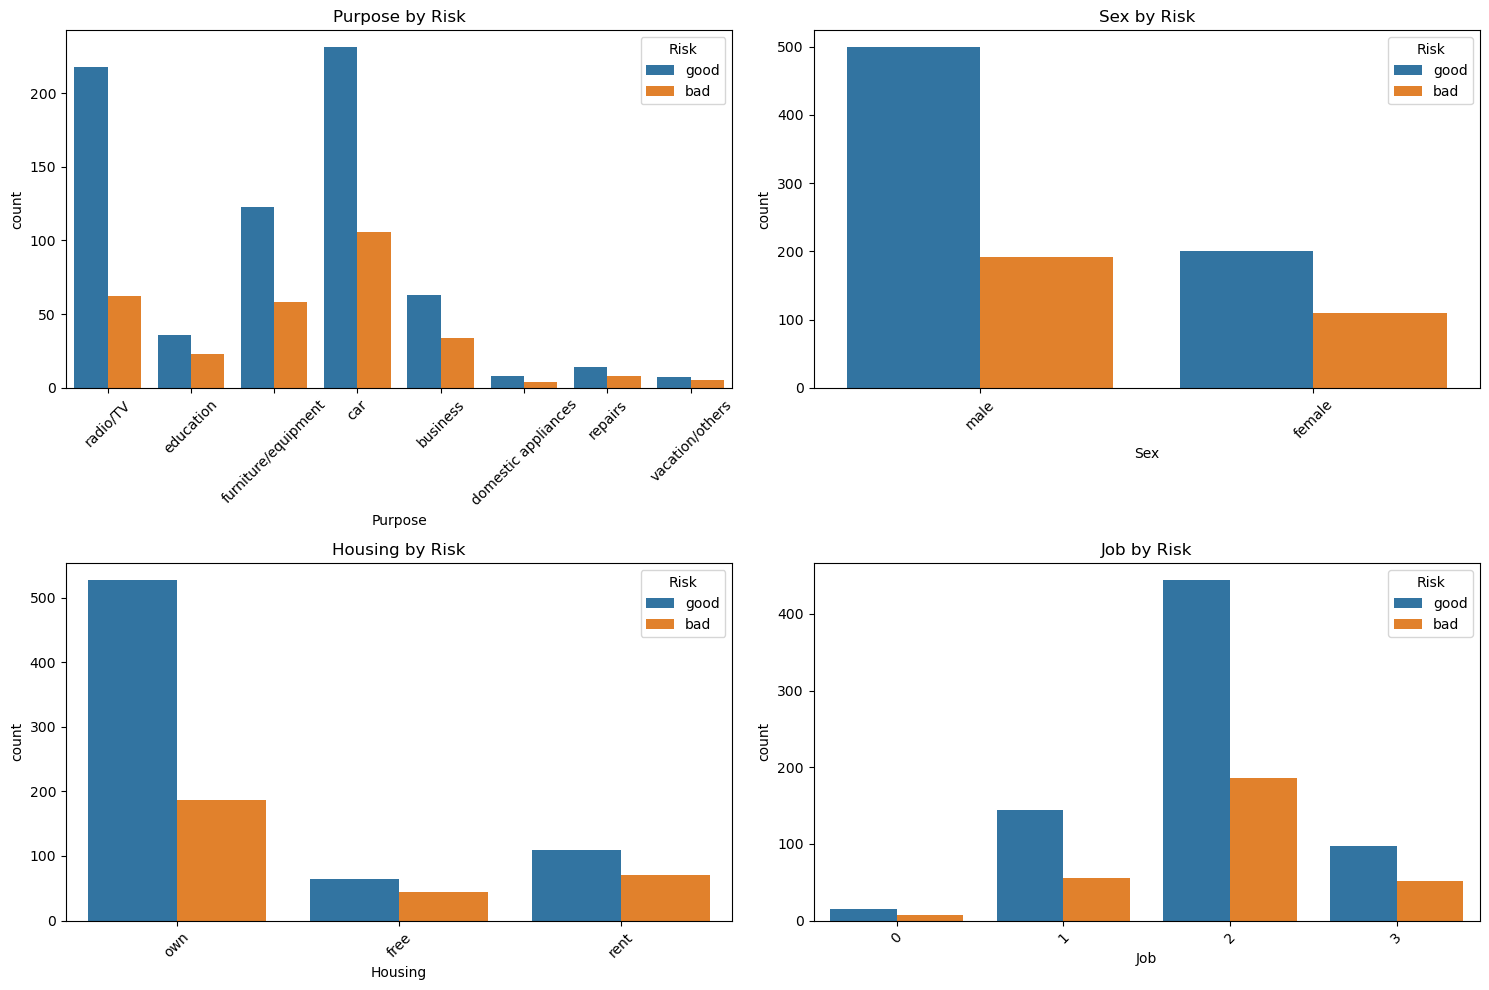

In [7]:
visualize_category_features(
    dataset=dataset,
    cat_columns=['Purpose', 'Sex', 'Housing', 'Job']
)

# EDA - Numerical features

In [8]:
from utils import visualize_numerical_features

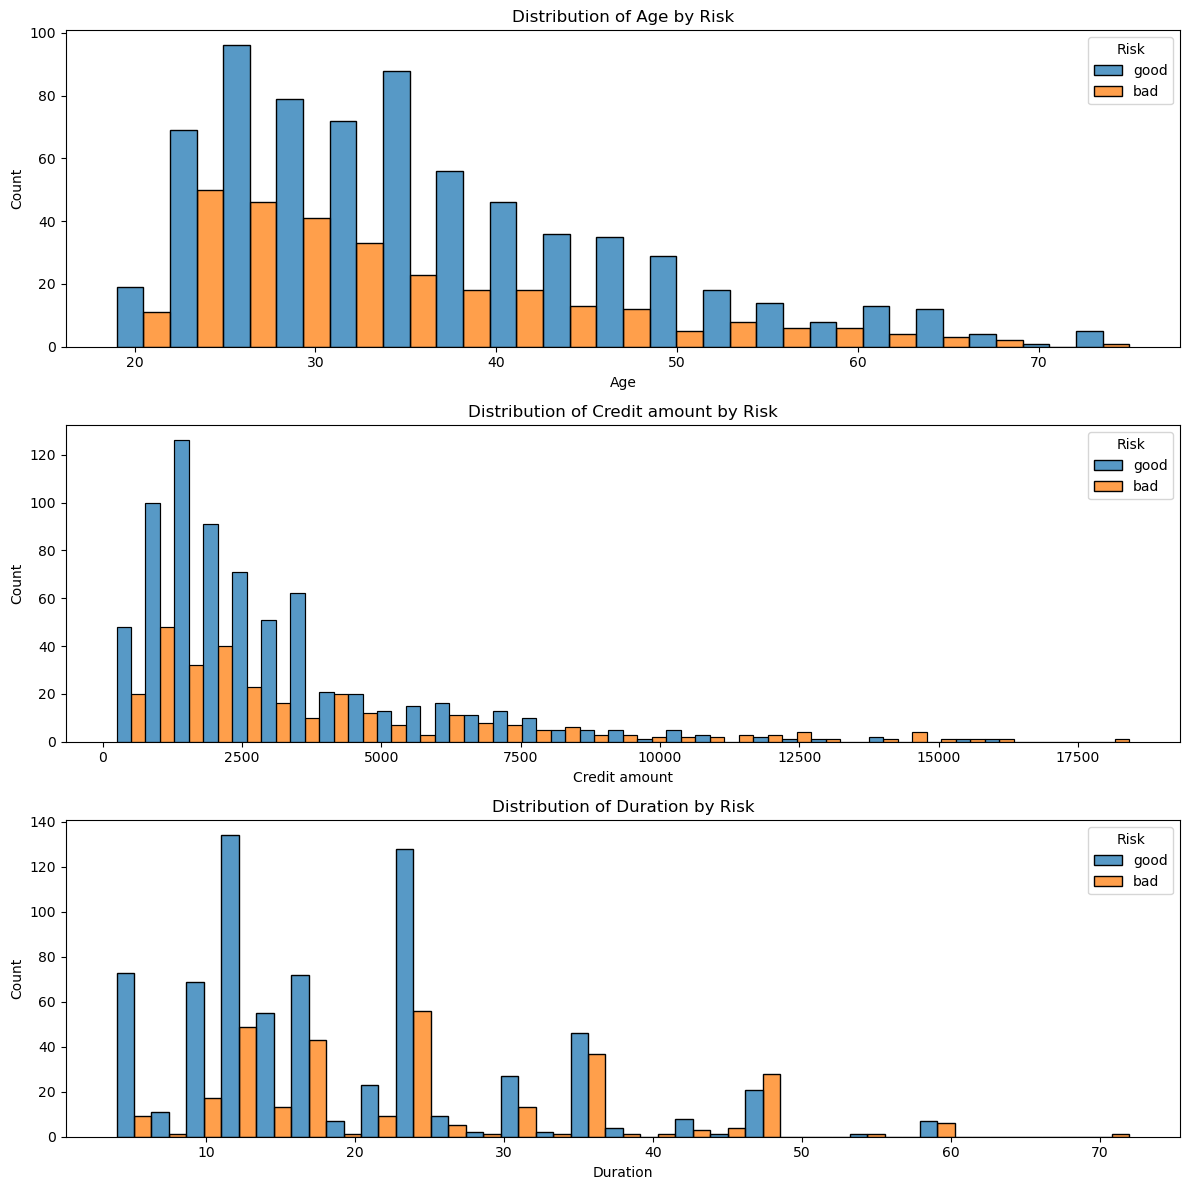

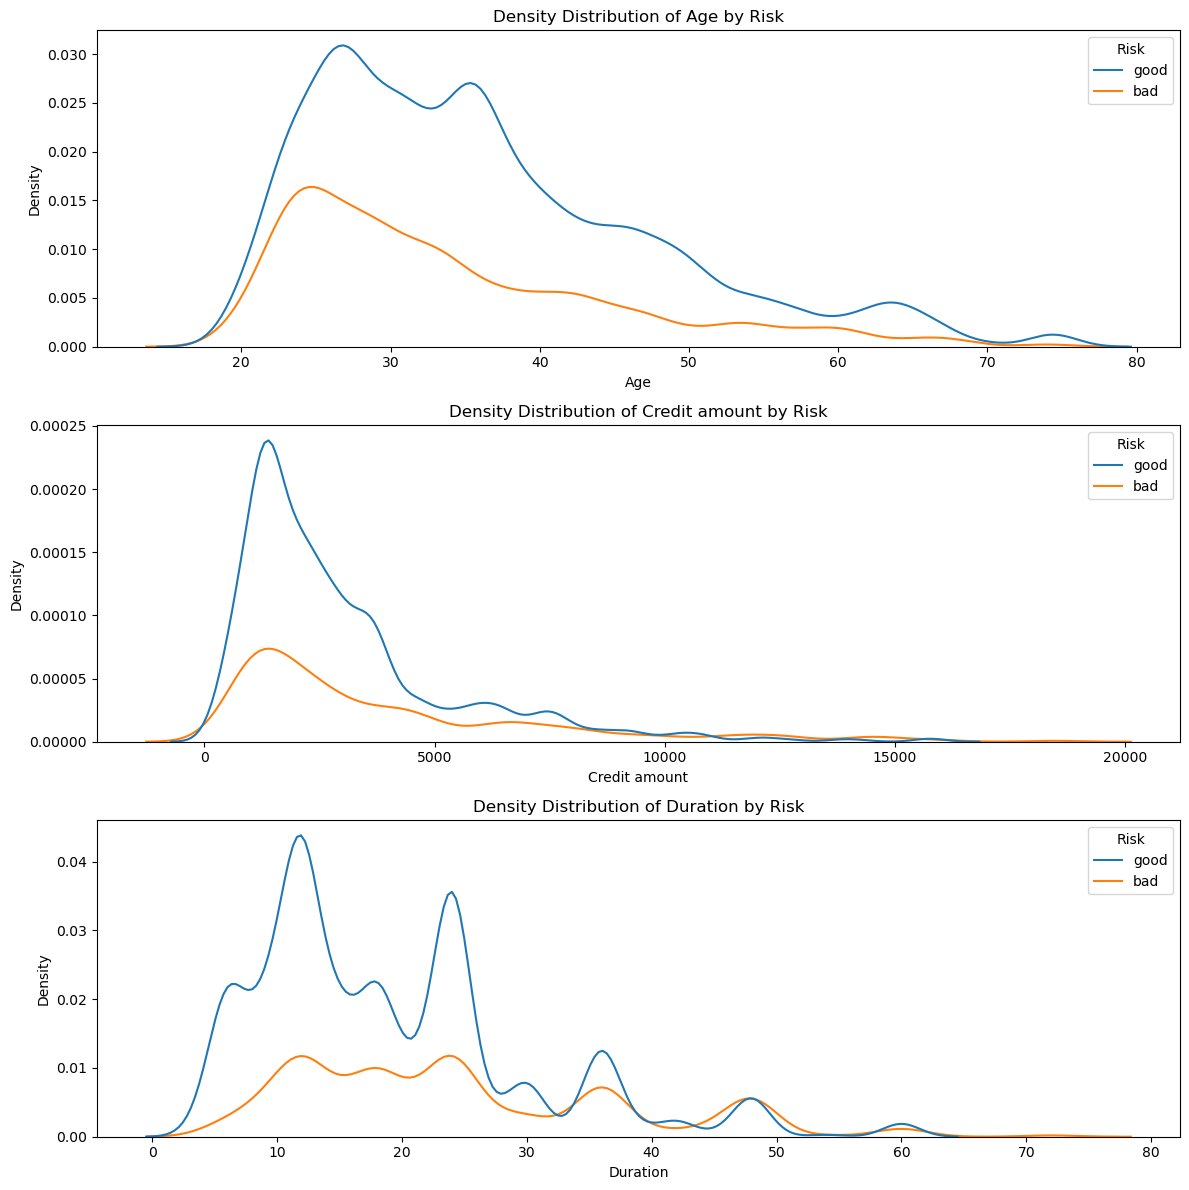

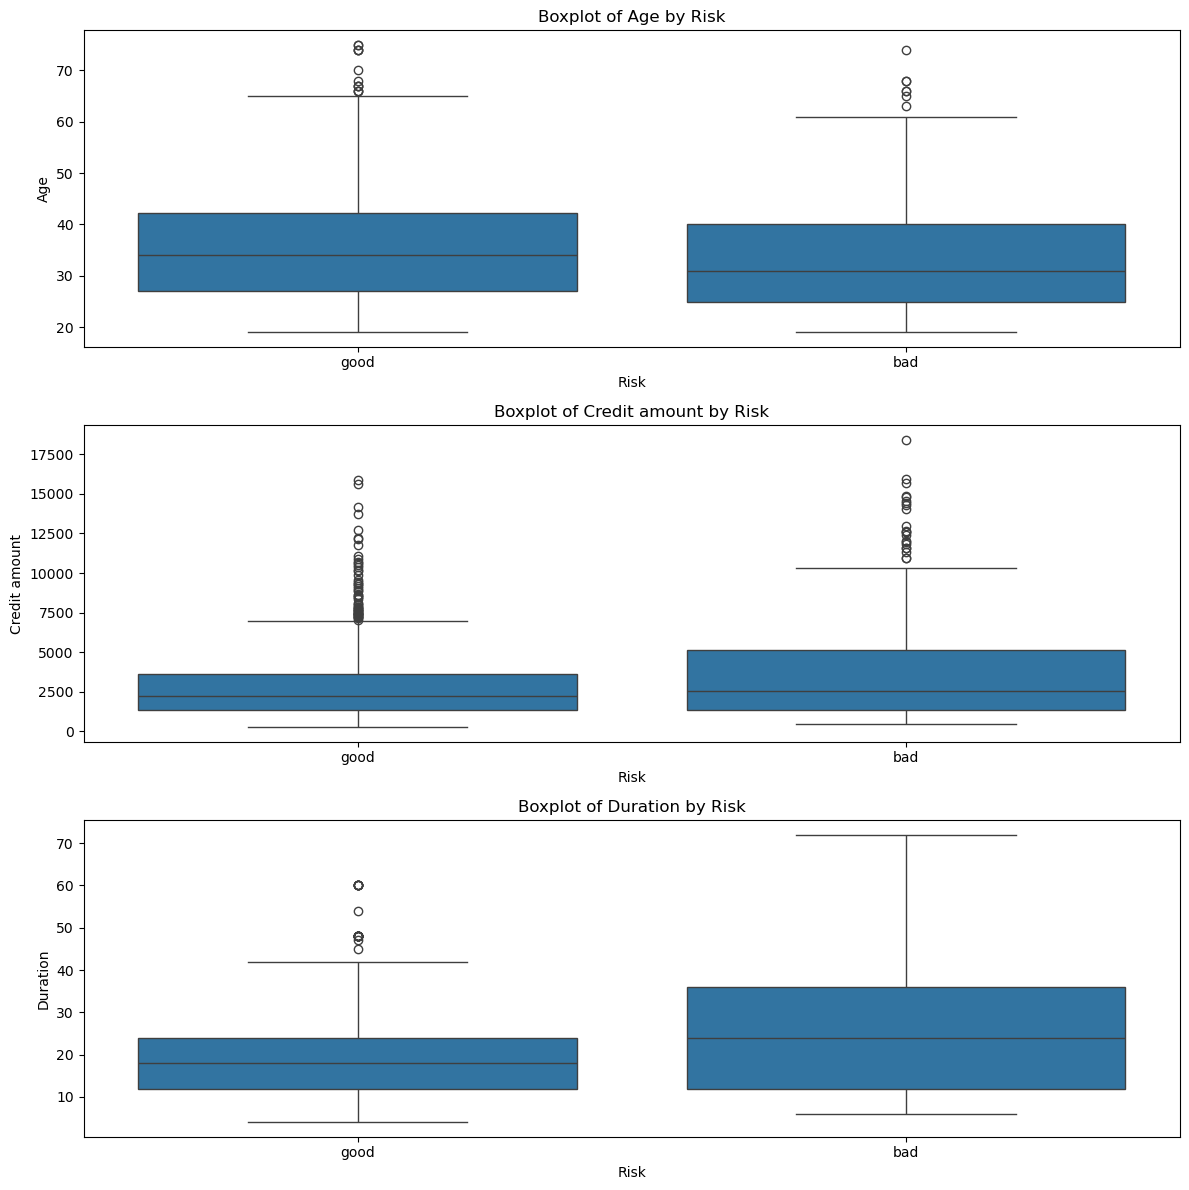

In [9]:
visualize_numerical_features(
    dataset=dataset,
    num_columns=['Age', 'Credit amount', 'Duration']
)

# EDA - Numerical and Categorical Features

In [54]:
from utils import plot_categorical_violin

In [39]:
dataset.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

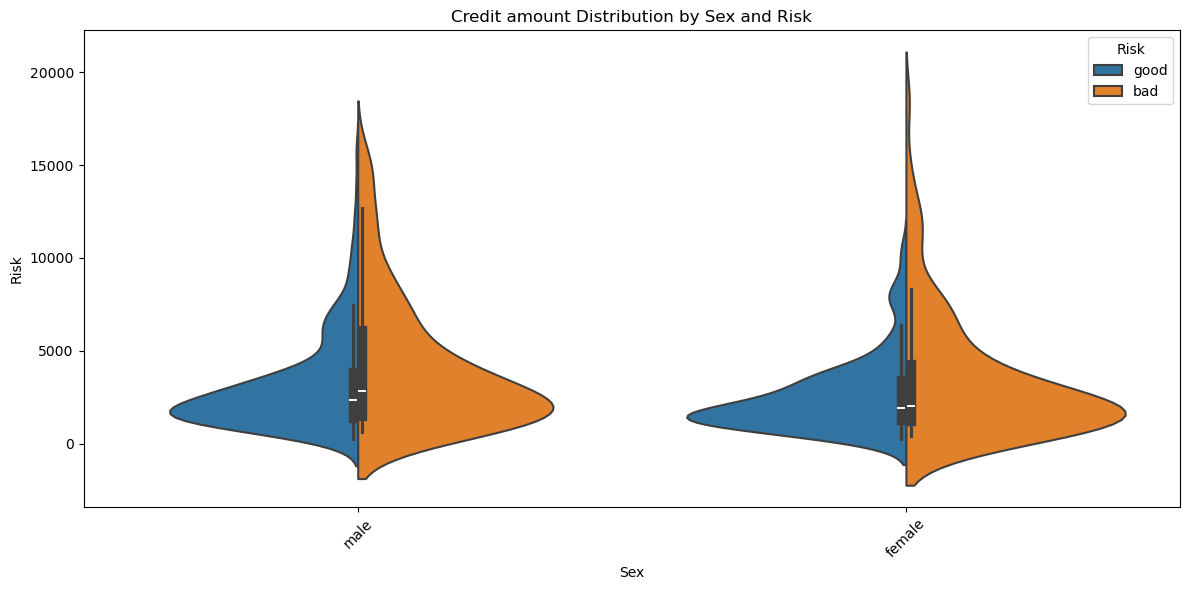

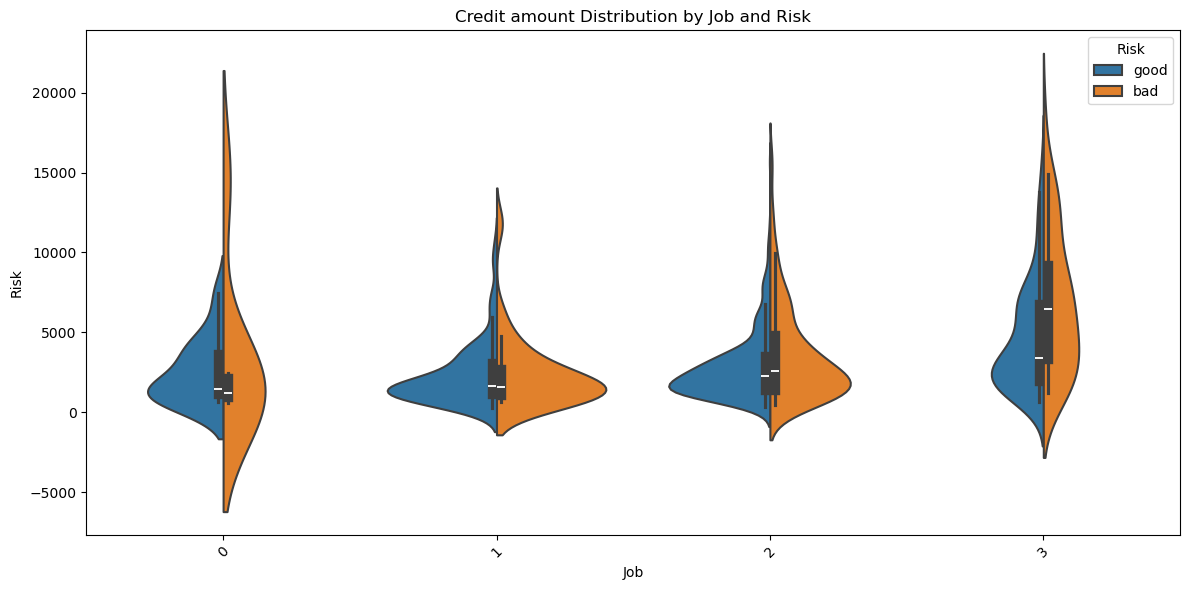

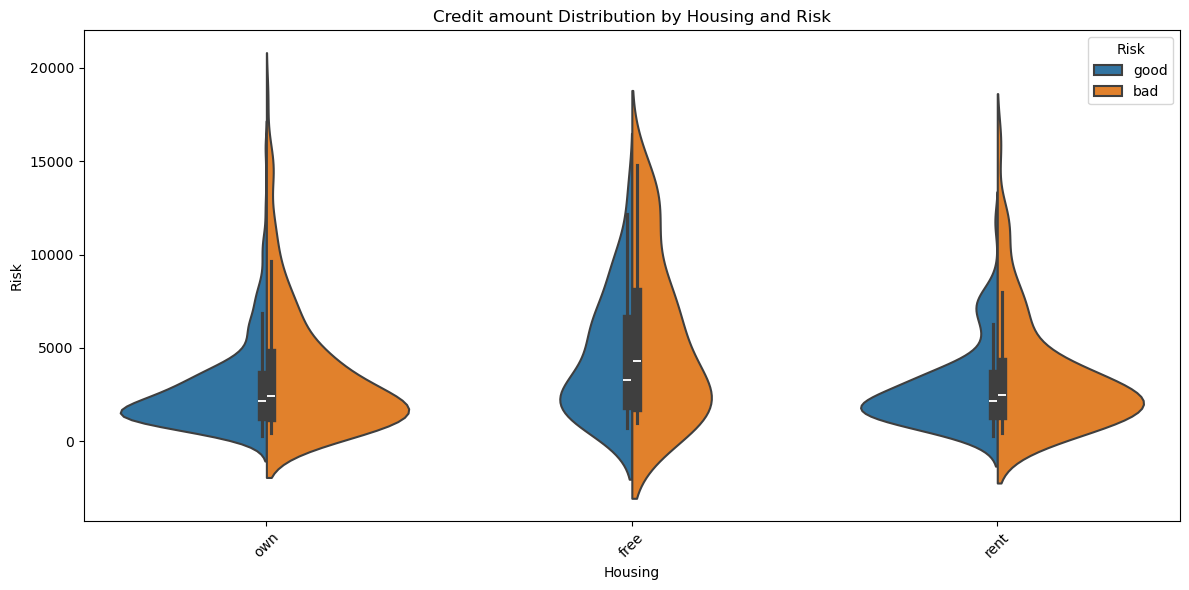

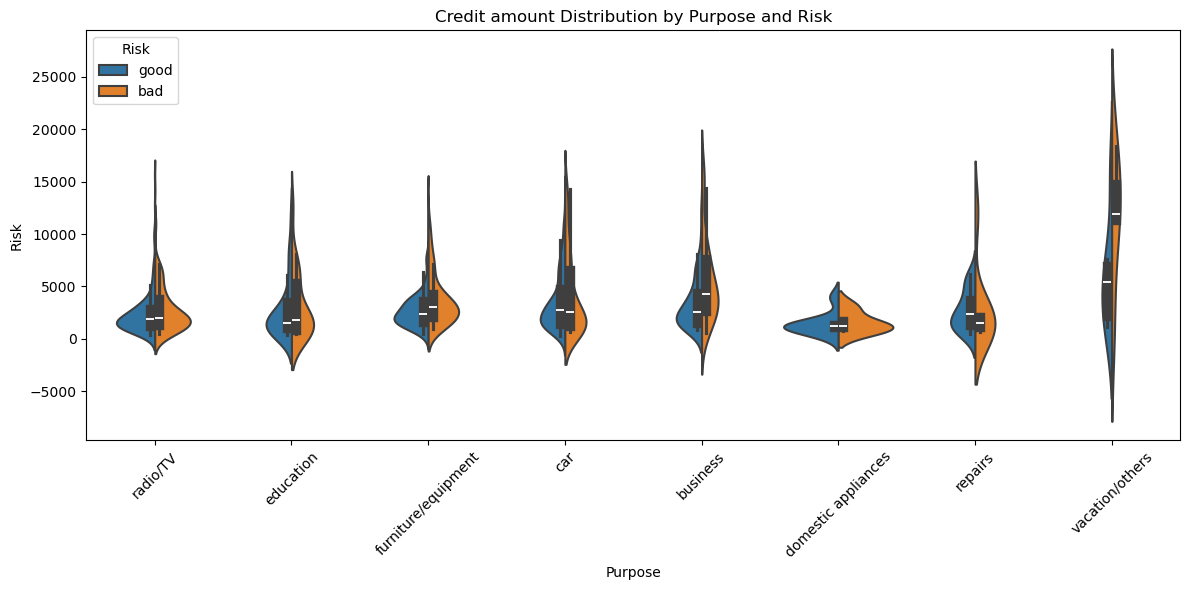

In [55]:
plot_categorical_violin(
    dataset=dataset,
    cat_column=['Sex','Job','Housing','Purpose'],
    num_column= 'Credit amount',
    target_column= 'Risk'
)

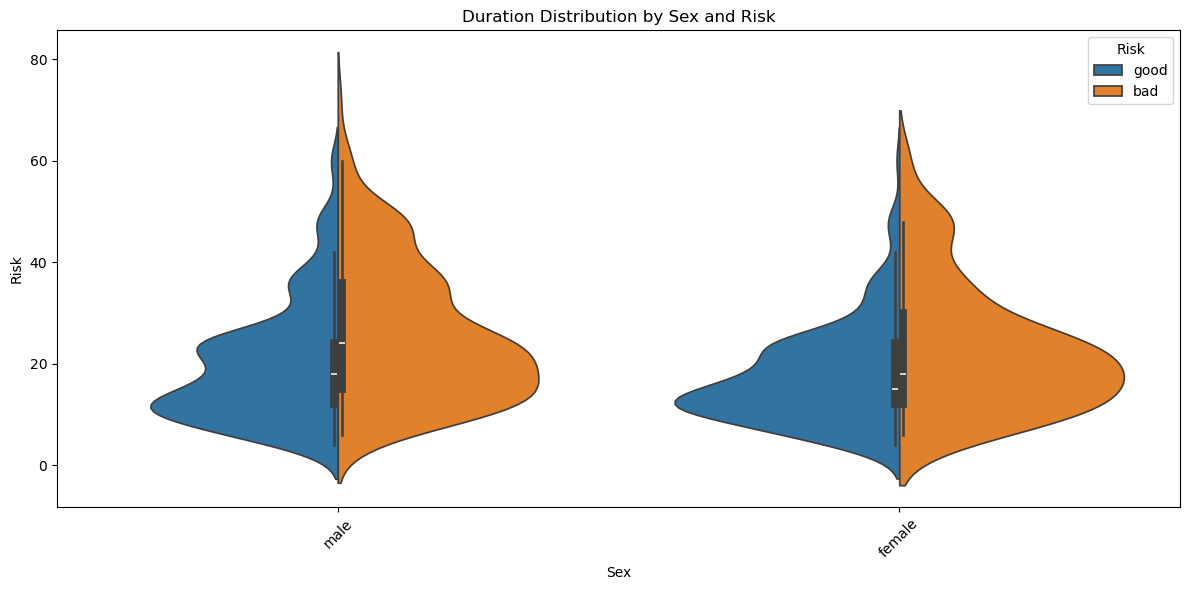

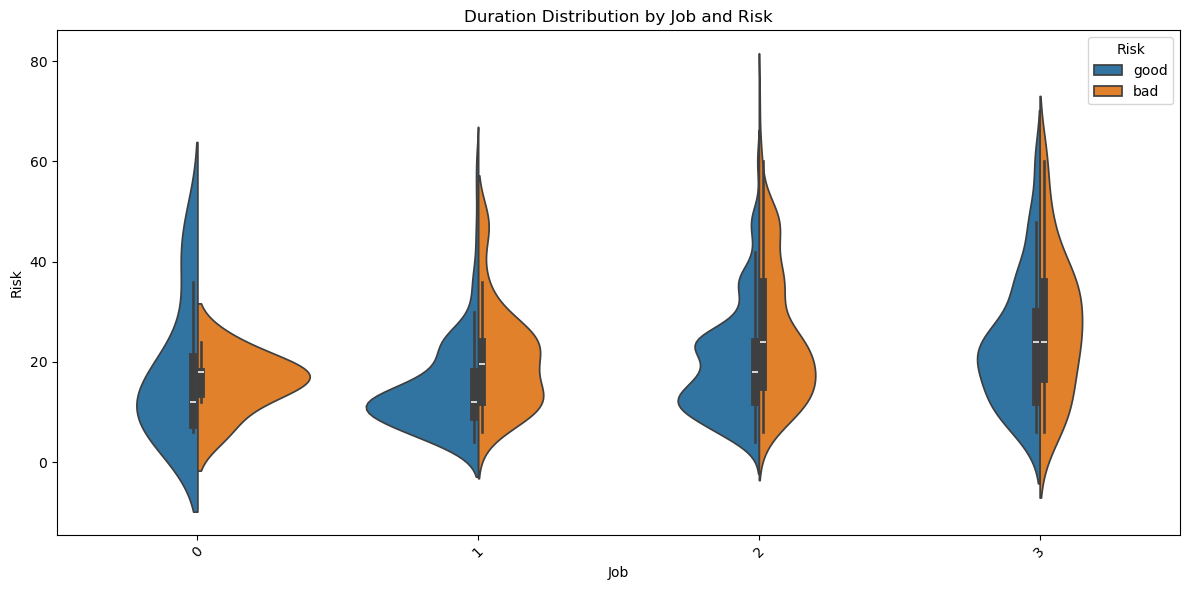

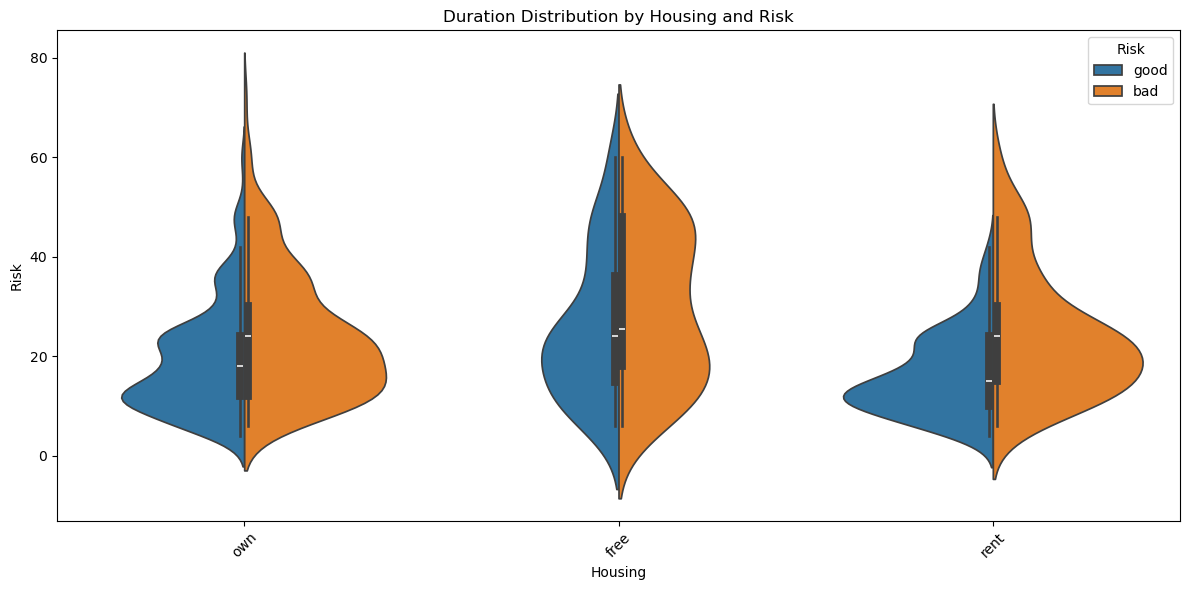

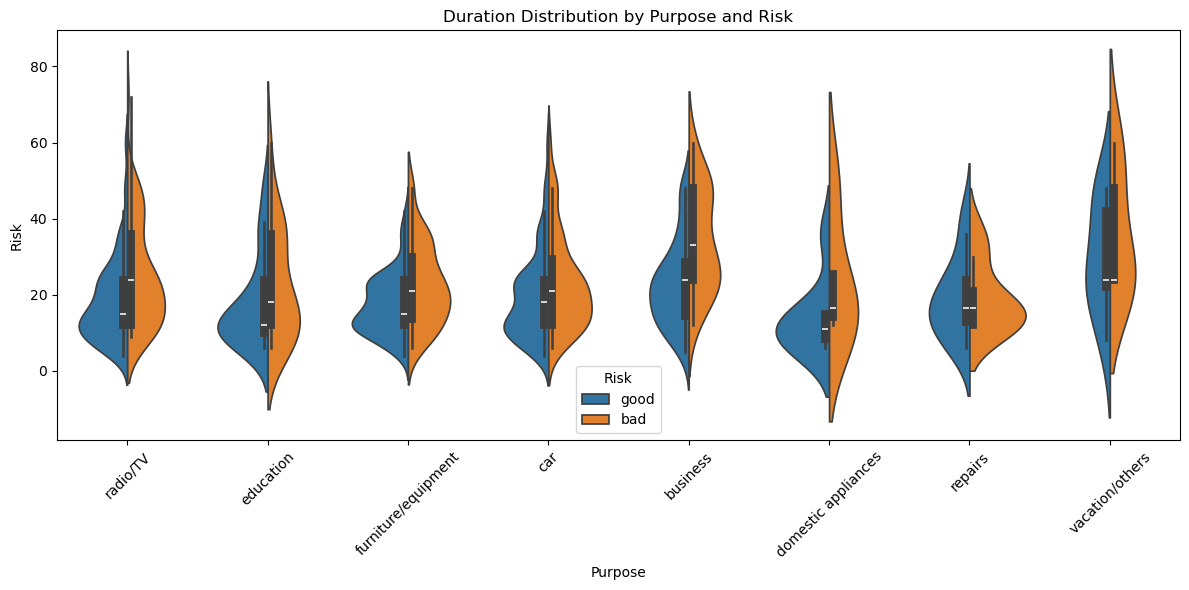

In [5]:
plot_categorical_violin(
    dataset=dataset,
    cat_column=['Sex','Job','Housing','Purpose'],
    num_column= 'Duration',
    target_column= 'Risk'
)

Comment:
Sex: Distribution of credit amount and duration vary little between female and male. No strong evidence high impact on credit risk

Job: Different jobs change the distribution of credit amount and duration significantly
    Job 0: more volatile bad/good proportion
            higher bad ratio in larger loans
            lower duration
            with lower duration having high bad ratio, strongly implying perceived risks.
    Job 1: stable risk profiles
        moderate credit amount and duration
        quite balanced good/bad ratio across credit amount and duration 
        slightly more good ratio in lower duration
Job 2: stable risk profiles but slightly longer duration and higher credit amount than Job 1 (implied worser perceived risk)
        balanced good/bad ratio across segments
Job 3: good group with higher credit amount, duration and more balanced good/bad ratios
        higher perceived safeness with higher duration and larger loans

Job 1 and Job 2 needs more information (other features) to decide whether good or bad, besides credit amount and duration. But overally, Job is evidently a strong factor giving diversification among its categories.

Purpose: visibly influential factor
        Vacation/others: Longer duration and higher credit amount, balanced good/bad ratios
        Business: higher bad ratio when duration increases
        Domestic appliances: smaller loans, higher bad ratio if longer duration
        Other purpose: moderate durations and loans, balanced good/bad ratios



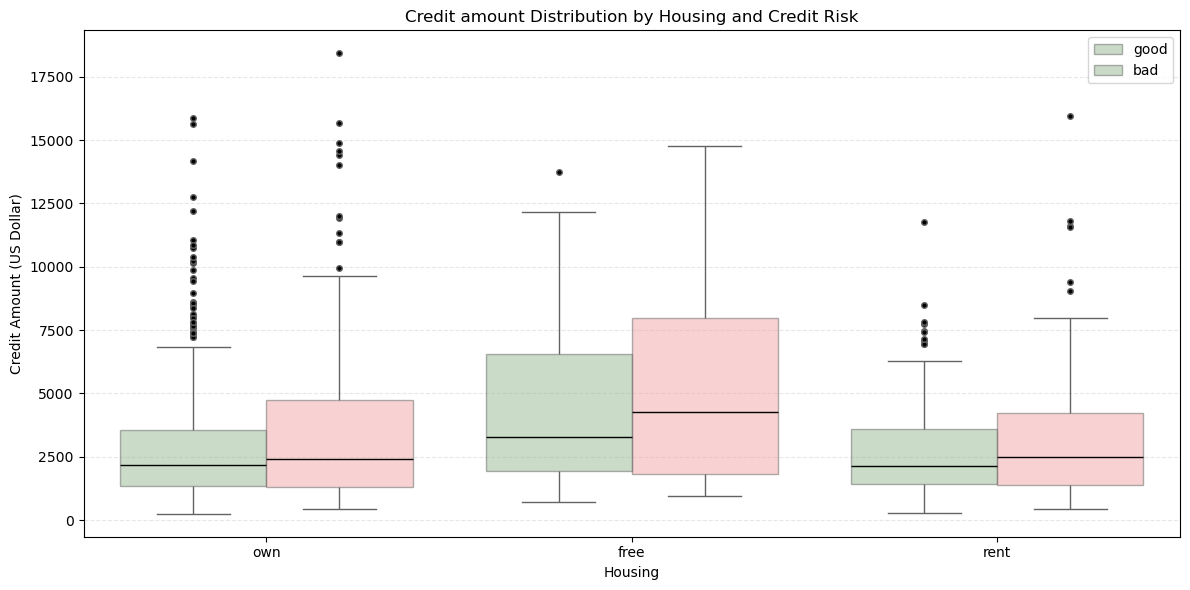

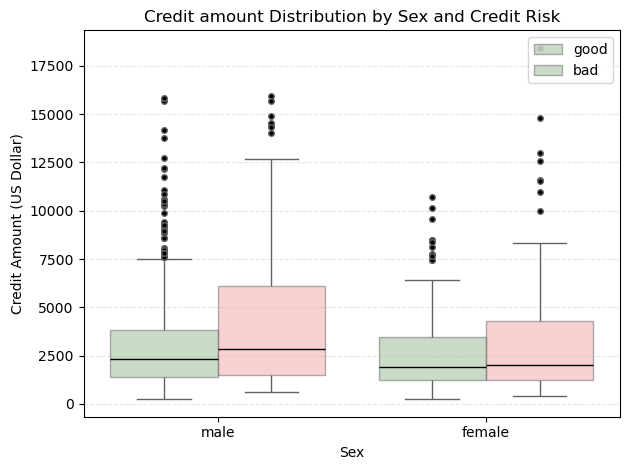

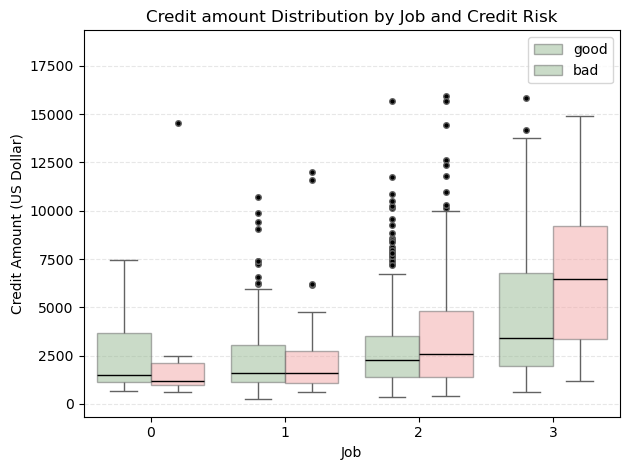

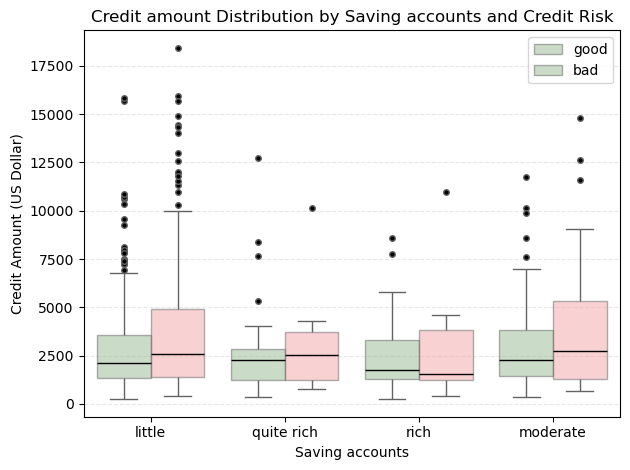

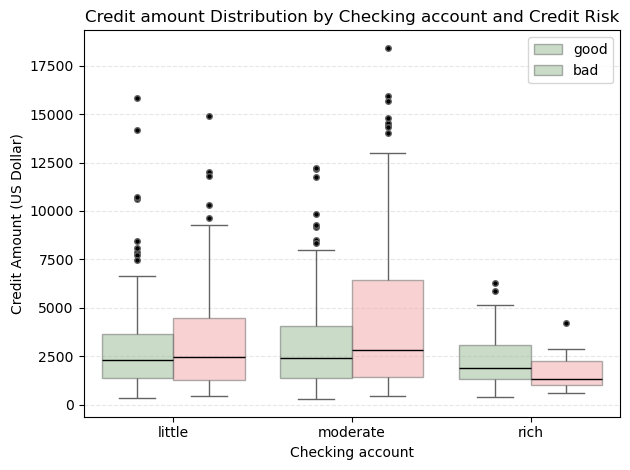

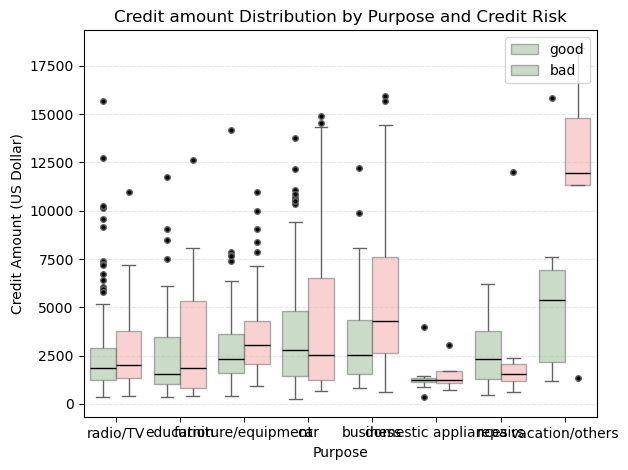

In [65]:
from utils import plot_credit_boxplot
plot_credit_boxplot(
    dataset = dataset,
    cat_column = ['Housing','Sex','Job','Saving accounts','Checking account', 'Purpose'],
    num_column= 'Credit amount',
    target_column= 'Risk'
)

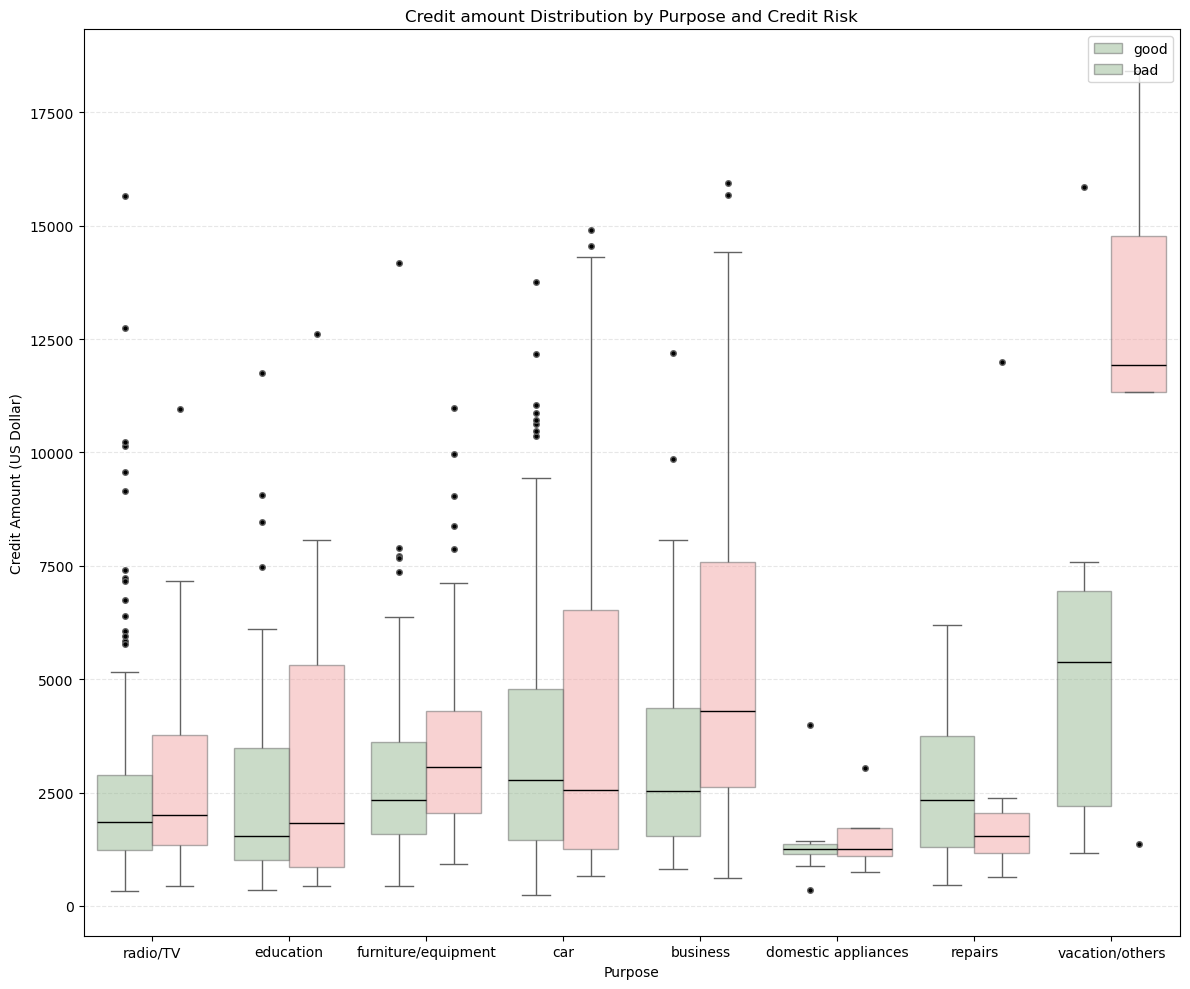

In [67]:
from utils import plot_credit_boxplot
plot_credit_boxplot(
    dataset=dataset,
    cat_column= ['Purpose'],
    num_column='Credit amount',
    target_column= 'Risk',
    figsize_length= 12,
    figsize_width= 10
)

# Processing

In [27]:
from utils import  processing_numerical_columns

from utils import  process_categorical_features


In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder


In [29]:
dataset = process_categorical_features(
    dataset = dataset,
    categories_columns=['Age', 'Sex', 'Job', 'Housing','Purpose','Saving accounts','Checking account','Risk'],
    fill_value = 'missing',
    encoding_type= 'label'
)

In [30]:
dataset = processing_numerical_columns(
    dataset = dataset,
    numerical_columns = ['Credit amount','Duration','Age'],
    fill_strategy='mean',
    handle_outliers= False,
    scaling_type='robust'
)

# Modelling

In [13]:
from utils import split_train_test
from utils import create_model_pipeline
from utils import train_evaluate
from utils import cross_validate_models

In [14]:
X_train, X_test , y_train, y_test = split_train_test(
    dataset = dataset,
    target_variable= 'Risk',
    test_size = 0.2,
    is_rebalance= True,
    positive_num= 560,
    negative_num= 240
)

Risk
1    560
0    240
Name: count, dtype: int64


In [144]:
pipeline = create_model_pipeline(
    model_name = 'rf'
)

metrics, trained_model = train_evaluate(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    model = pipeline,
    threshold = 0.5
)

In [145]:
metrics

{'accuracy': 0.755,
 'precision': 0.7861635220125787,
 'recall': 0.8928571428571429,
 'f1': 0.8361204013377926,
 'auc': 0.7413095238095238}

# Evaluation and Tuning

In [20]:
cross_validate_models(
    X=X,
    y=y
)

NameError: name 'X' is not defined

In [139]:
from utils import  plot_threshold_analysis
from utils import find_optimal_threshold
 

/Users/tramynguyen/Work/German-Credit-Risk/utils.py:214: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


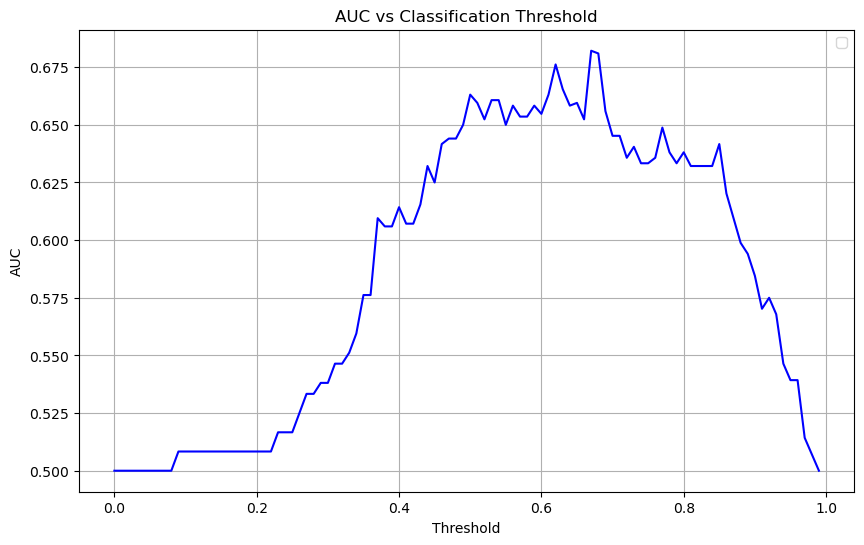

In [147]:
plot_threshold_analysis(
    model = pipeline,
    X_test = X_test,
    y_test = y_test,
    target_label = 1
)

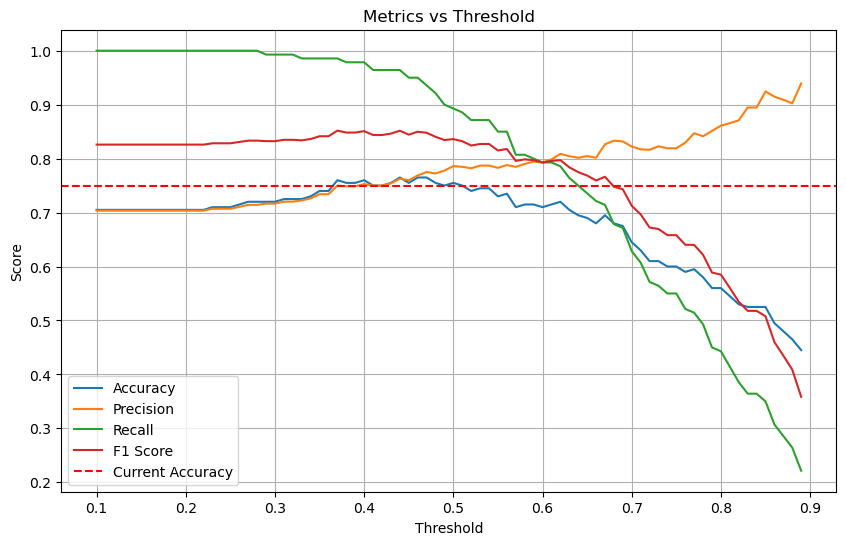

Best threshold for accuracy: 0.440
Best accuracy score: 0.765

Best threshold for F1: 0.370
Best F1 score: 0.852


In [148]:
best_threshold_accuracy, best_threshold_f1 = find_optimal_threshold(
    model = pipeline,
    X_test = X_test,
    y_test = y_test,
    current_accuracy= 0.75
)

In [150]:
metrics, trained_model = train_evaluate(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    model = pipeline,
    threshold = 0.44
)

metrics

{'accuracy': 0.765,
 'precision': 0.7627118644067796,
 'recall': 0.9642857142857143,
 'f1': 0.8517350157728707,
 'auc': 0.7413095238095238}

# Scorecard model

In [55]:
from utils import (
    ScoreScalingParameters, 
    calculate_woe_iv
)

In [10]:
factor, offset = ScoreScalingParameters()

In [31]:
X = dataset[ [col for col in dataset.columns if col != 'Risk'] ]

In [32]:
y = dataset['Risk']

In [33]:
columns_to_convert = ['Sex', 'Job', 'Housing', 'Saving accounts', 
                      'Checking account', 'Purpose' ]
X[columns_to_convert] = dataset[columns_to_convert].astype(str)

/var/folders/xj/c22cjmmx1ql3qrd9jvv30qfh0000gn/T/ipykernel_1280/4161552629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[columns_to_convert] = dataset[columns_to_convert].astype(str)


In [34]:
X.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [56]:
woe_dict, iv_dict = calculate_woe_iv(
    X = X,
    y = y,
    features = X.columns,
    bins = 10
)

/Users/tramynguyen/Work/German-Credit-Risk/utils.py:514: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_dict = {}
/Users/tramynguyen/Work/German-Credit-Risk/utils.py:514: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_dict = {}
/Users/tramynguyen/Work/German-Credit-Risk/utils.py:514: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iv_dict = {}
/Users/tramynguyen/Work/German-Credit-Risk/utils.py:514: FutureWarning: The 

In [57]:
woe_dict

{Interval(-0.001, 99.9, closed='right'): -0.23815634370339492,
 Interval(99.9, 199.8, closed='right'): 0.1017042044547159,
 Interval(199.8, 299.7, closed='right'): -0.3459796548219843,
 Interval(299.7, 399.6, closed='right'): -0.0863846141988207,
 Interval(399.6, 499.5, closed='right'): -0.0863846141988207,
 Interval(499.5, 599.4, closed='right'): 0.48701497507227215,
 Interval(599.4, 699.3, closed='right'): 0.009411834182346597,
 Interval(699.3, 799.2, closed='right'): 0.1017042044547159,
 Interval(799.2, 899.1, closed='right'): -0.03800932596698429,
 Interval(899.1, 999.0, closed='right'): 0.1017042044547159,
 'Unnamed: 0': {...},
 Interval(-0.001, 4.0, closed='right'): 0.44576203041892876,
 Interval(4.0, 7.0, closed='right'): 0.3832643981279718,
 Interval(7.0, 9.0, closed='right'): 0.0,
 Interval(9.0, 11.0, closed='right'): 0.18286078570968972,
 Interval(11.0, 14.0, closed='right'): 0.07525673735759514,
 Interval(14.0, 17.0, closed='right'): -0.4787042704765667,
 Interval(17.0, 20.0

In [58]:
iv_dict

{'Unnamed: 0': 0.04745191434048653,
 'Age': 0.09877581201676189,
 'Sex': 9.059510337184113e-07,
 'Job': 0.008244786561456555,
 'Housing': 0.03926946672013515,
 'Saving accounts': 0.0722470221870792,
 'Checking account': 0.06841202863149533,
 'Credit amount': 0.11207414267006709,
 'Duration': 0.24416165143500418,
 'Purpose': 0.06467605805880423}